# 프로젝트: 퍼스널 컬러 진단 - ResNet18

## 데이터
일반인 웜 490장, 쿨 186장  

## 목표: ResNet18에 퍼스널 컬러 진단 분류하기  

## (1) 라이브러리 및 데이터 불러오기

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import vgg16

import numpy as np
import cv2
import os
import glob
from PIL import Image

In [2]:
# 파일 불러오는 함수
def load_images_from_directory(directory_path):
    image_paths = glob.glob(directory_path + '/*.jpg')  # 디렉토리 내의 모든 jpg 파일 경로 찾기
    image_paths.extend(glob.glob(directory_path + '/*.jpeg'))  # 디렉토리 내의 모든 jpeg 파일 경로 추가
    image_paths = glob.glob(directory_path + '/*.JPG')  # 디렉토리 내의 모든 JPG 파일 경로 찾기

    images = []
    i = 0
    for image_path in image_paths:
        if i == 150:
            break
        image = Image.open(image_path)
        image_np = np.array(image)
        images.append(image_np)
        i += 1

    return images

In [3]:
# 모든 이미지 불러오기
directory_path = "/aiffel//aiffel/project/first-repository/data/four_seasons/train_warm_1"  # 디렉토리 경로
directory_path2 = "/aiffel/aiffel/project/first-repository/data/four_seasons/train_cool_1/cool_1"  # 디렉토리 경로
images = load_images_from_directory(directory_path)
images2 = load_images_from_directory(directory_path2)

length = len(images)
print(length)
print(len(images2))

# 이미지 리스트 합치기
images = np.concatenate((images, images2), axis=0)
print(len(images))

150
150
300


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## (2) 데이터 전처리

In [12]:
def preprocess_image(image):
    # 이미지 크기 조절
    image = tf.image.resize(image, (224, 224))
    # 이미지를 [0, 1] 범위로 정규화
    image = image / 255.0
    return image

images = np.array([preprocess_image(image) for image in images])
print(images.shape)

(300, 224, 224, 3)


In [13]:
from tensorflow.keras.utils import to_categorical

# labels에 대한 코드
num = len(images)
labels = np.zeros(num)

# 뒤쪽의 50개의 요소를 1로 변경
labels[length:] = 1

labels = to_categorical(labels, num_classes=2)

# 0이 웜톤 1이 쿨톤
print(len(images))
print(labels.shape)
print(labels)

300
(300, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0

In [24]:
from keras.preprocessing.image import ImageDataGenerator

# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(images, batch_size=8)

## (3) trian, val 분리하기

In [25]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images,
                                                  labels,
                                                  test_size=0.3,
                                                  random_state=88)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (210, 224, 224, 3)
y_train:  (210, 2)
x_val:  (90, 224, 224, 3)
y_val:  (90, 2)


In [26]:
# 데이터를 텐서로 변환
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

## (4) 모델 정의 및 컴파일

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Add, Activation
from tensorflow.keras.models import Model


def build_resnet18(input_shape, num_classes):
    # Residual block function
    def residual_block(x, filters, strides=(1, 1)):
        identity = x

        # First convolutional layer
        x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Second convolutional layer
        x = Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
        x = BatchNormalization()(x)

        # Skip connection (identity)
        if strides != (1, 1) or identity.shape[-1] != filters:
            identity = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(identity)
            identity = BatchNormalization()(identity)

        x = Add()([x, identity])
        x = Activation('relu')(x)
        return x

    inputs = tf.keras.Input(shape=input_shape)
    x = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = residual_block(x, filters=64, strides=(1, 1))
    x = residual_block(x, filters=64, strides=(1, 1))
    x = residual_block(x, filters=32, strides=(2, 2))
    x = residual_block(x, filters=32, strides=(1, 1))
    x = residual_block(x, filters=16, strides=(2, 2))
    x = residual_block(x, filters=16, strides=(1, 1))
    x = residual_block(x, filters=16, strides=(2, 2))
    x = residual_block(x, filters=16, strides=(1, 1))

    # Global average pooling and classification layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='sigmoid')(x)

    # Create model
    model = Model(inputs, outputs)
    return model

# ResNet18 모델 빌드
model = build_resnet18(input_shape=(224, 224, 3), num_classes=2)

# 모델 요약 정보 출력
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 112, 112, 64) 256         conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 112, 112, 64) 0           batch_normalization_40[0][0]     
____________________________________________________________________________________________

In [28]:
from keras.callbacks import ReduceLROnPlateau

# 콜백 생성
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)

# 모델을 평가 모드로 설정 (학습이 아닌 추론용으로 사용할 때 필요)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## (5) 모델 학습하기

In [29]:
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=20,
                    validation_data=(x_val, y_val), 
                    callbacks=[reduce_lr])

Epoch 1/20
14/14 [==============================] - 3s 75ms/step - loss: 0.6491 - accuracy: 0.5667 - val_loss: 0.6934 - val_accuracy: 0.5111
Epoch 2/20
14/14 [==============================] - 1s 41ms/step - loss: 0.4032 - accuracy: 0.8381 - val_loss: 0.7066 - val_accuracy: 0.5111
Epoch 3/20
14/14 [==============================] - 1s 40ms/step - loss: 0.2891 - accuracy: 0.8667 - val_loss: 0.7890 - val_accuracy: 0.5111
Epoch 4/20
14/14 [==============================] - 1s 41ms/step - loss: 0.2343 - accuracy: 0.9143 - val_loss: 0.9663 - val_accuracy: 0.5111
Epoch 5/20
14/14 [==============================] - 1s 40ms/step - loss: 0.2090 - accuracy: 0.9048 - val_loss: 1.0944 - val_accuracy: 0.5111
Epoch 6/20
14/14 [==============================] - 1s 40ms/step - loss: 0.1733 - accuracy: 0.9524 - val_loss: 1.1988 - val_accuracy: 0.5111
Epoch 7/20
14/14 [==============================] - 1s 40ms/step - loss: 0.1669 - accuracy: 0.9286 - val_loss: 1.2817 - val_accuracy: 0.5111
Epoch 8/20
14

## (6) 예측하기

In [30]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
y_val = np.argmax(y_val, axis=1)

In [31]:
print(pred_class)
print(y_val)
print(pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1
 1 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0]
[[0.02374389 0.964984  ]
 [0.0237282  0.9649589 ]
 [0.02384923 0.96495605]
 [0.02360288 0.9649203 ]
 [0.02388206 0.9647231 ]
 [0.02371479 0.9648596 ]
 [0.02382259 0.9647932 ]
 [0.02356857 0.9648527 ]
 [0.02373505 0.96494395]
 [0.02365374 0.96487635]
 [0.02371704 0.9648945 ]
 [0.02373973 0.9650164 ]
 [0.0237277  0.9648303 ]
 [0.02363528 0.9649598 ]
 [0.02381601 0.9650332 ]
 [0.02390468 0.96474   ]
 [0.02370592 0.9648635 ]
 [0.02377106 0.96501935]
 [0.02395892 0.9647918 ]
 [0.02377902 0.96479315]
 [0.02366365 0.9649396 ]
 [0.02384382 0.96467376]
 [0.02387554 0.964774  ]
 [0.02401641 0.964677  ]
 [0.02383963 0.9648286 ]
 [0.023

In [32]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.511111


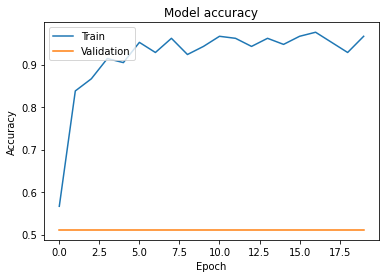

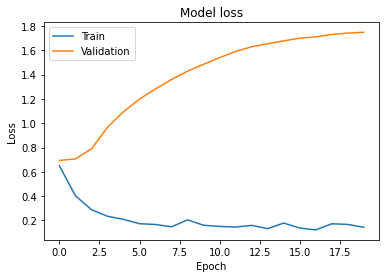

In [33]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## (7) TEST

In [ ]:
class_name = ["웜톤", "쿨톤"]

In [ ]:
# test 불러오기 (낱개 버전)
test_path = "/aiffel/aiffel/project/first-repository/data/four_seasons/TEST/박은빈.jpg"
x_test = Image.open(test_path)
x_test = np.array(x_test)
print(x_test.shape)

# 배열의 크기 변환
x_test = x_test.reshape((1, x_test.shape[0], x_test.shape[1], 3))
print("변환된 배열 크기:", x_test.shape)

# 전처리(resize, 정규화)
x_test = preprocess_image(x_test)
print(x_test.shape)

# 만약 앱구현과 연결된다면 저장된 모델을 다시 돌릴 필요없이 저장된 최적의 모델을 사용하도록 수정해야함
# test
pred = model.predict(x_test)
pred_class = np.argmax(pred, axis=1)
print("당신은", class_name[int(pred_class)], "입니다~!")
print("웜톤일 확률: ", np.round(pred[:, 0], 3))
print("쿨톤일 확률: ", np.round(pred[:, 1], 3))